In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

%load_ext autoreload
%autoreload 2

In [52]:
import pickle

import matplotlib.pyplot as plt

import detection_eval_utils as utils

# Evaluate MegaDetector v2 and v3 on the v3 validation set

This validation set is not the perfect measure of performance for either version, since there are some images in there that are in the training set of MDv2, and that MDv3's checkpoint was selected based on results on ~10% of this validation set.

This validation set is relatively noise-less however, since they were bounding box labeled by iMerit.

In [17]:
# using results that exclude the 'person' category, since this is newly added in v3

with open('/Users/siyuyang/Source/temp_data/CameraTrap/megadetectorv3/no_human_images/v2_on_val_v3/per_category_metrics.p', 'rb') as f:
    v2_results = pickle.load(f)
    
with open('/Users/siyuyang/Source/temp_data/CameraTrap/megadetectorv3/no_human_images/v3/per_category_metrics.p', 'rb') as f:
    v3_results = pickle.load(f)

In [18]:
v2_animal = v2_results[0][1]

In [19]:
v2_animal

{'average_precision': 0.8301842585885212,
 'category': 1,
 'num_gt': 19562,
 'precision': array([1.        , 1.        , 1.        , ..., 0.01208208, 0.01208207,
        0.01208206]),
 'recall': array([5.11195174e-05, 1.02239035e-04, 1.53358552e-04, ...,
        9.03435232e-01, 9.03435232e-01, 9.03435232e-01]),
 'scores': array([9.99992728e-01, 1.71653973e-03, 4.61522082e-04, ...,
        1.67497019e-05, 1.62780798e-05, 1.61811004e-05]),
 'tp_fp': array([ True, False, False, ..., False, False, False])}

In [20]:
v2_recall_at_90_prec = utils.find_precision_at_recall(v2_animal['precision'], v2_animal['recall'], recall_level=0.9)
v2_recall_at_90_prec

0.028376270050028365

In [21]:
v3_animal = v3_results[0][1]
v3_animal

{'average_precision': 0.8978631413464984,
 'category': 1,
 'num_gt': 19562,
 'precision': array([1.        , 1.        , 1.        , ..., 0.01421641, 0.0142164 ,
        0.01421639]),
 'recall': array([5.11195174e-05, 1.02239035e-04, 1.53358552e-04, ...,
        9.47244658e-01, 9.47244658e-01, 9.47244658e-01]),
 'scores': array([9.78884995e-01, 7.63085961e-01, 3.37921143e-01, ...,
        2.64870578e-05, 2.57388328e-05, 2.35880652e-05]),
 'tp_fp': array([False, False,  True, ..., False, False, False])}

In [22]:
v3_recall_at_90_prec = utils.find_precision_at_recall(v3_animal['precision'], v3_animal['recall'], recall_level=0.9)
v3_recall_at_90_prec

0.5890067244321033

In [62]:
# percentage gain in AP
100 * (v3_animal['average_precision'] - v2_animal['average_precision']) / v2_animal['average_precision']

8.152272469372615

In [63]:
# percentage gain in precision at 90% recall
100 * (v3_recall_at_90_prec - v2_recall_at_90_prec)/v2_recall_at_90_prec

1975.7017162356562

### Plot precision-recall for the `animal` category on one graph

<Figure size 750x750 with 0 Axes>

Text(0.5,0,'Recall')

Text(0,0.5,'Precision')

(0, 1.05)

(0, 1.05)

Text(0.5,1,'MegaDetector v2 and v3 precision-recall \non v3 validation set')

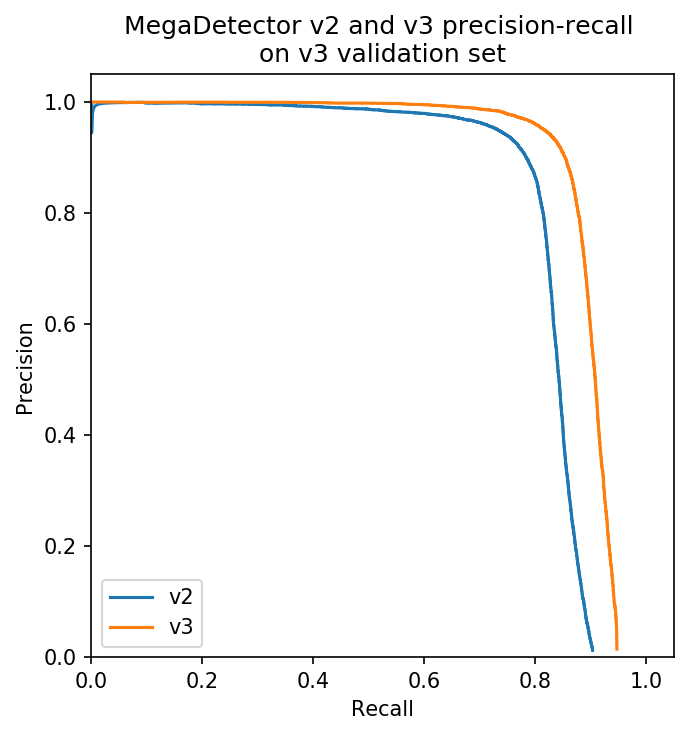

In [50]:
plt.figure(figsize=(5, 5), dpi=150)

plt.plot(v2_animal['recall'], v2_animal['precision'], label='v2')
plt.plot(v3_animal['recall'], v3_animal['precision'], label='v3')

plt.xlabel('Recall')
plt.ylabel('Precision')     
plt.xlim([0, 1.05])
plt.ylim([0, 1.05])
plt.title('MegaDetector v2 and v3 precision-recall \non v3 validation set')
plt.axes().set_aspect('equal')
plt.legend(loc='lower left')
plt.tight_layout()
plt.savefig('/Users/siyuyang/Source/temp_data/CameraTrap/megadetectorv3/no_human_images/v2_v3_animal.png')

### TP at 90% confidence and 0.5 IoU

In [56]:
len(v2_animal['tp_fp'])
len(v3_animal['tp_fp'])

1462747

1303425

In [67]:
conf_threshold = 0.9

tp_fp_confident = [[], []]

for i_version, version in enumerate((v2_animal, v3_animal)):
    for s, tf in zip(version['scores'], version['tp_fp']):
        if s > 0.9:
            tp_fp_confident[i_version].append(tf)

In [74]:
len(tp_fp_confident[0])
len(tp_fp_confident[1])

17087

16738

In [68]:
total_gt = 19562

v2_tp = sum(tp_fp_confident[0]) / total_gt
v3_tp = sum(tp_fp_confident[1]) / total_gt

v2_tp
v3_tp

0.7850424291994683

0.8143339126878643

Need to be able to record down false negatives.